# Evaluationg OPE estimators

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
cd zr-obp/


/home/foundry/jupyter/shion.ishikawa/workspace/research/zr-obp


In [3]:
from tqdm import tqdm

from obp.ope.estimators import InverseProbabilityWeighting
from obp.policy.linear import LinTS
from obp.policy.contextfree import BernoulliTS, Random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from obp.dataset import SyntheticBanditDataset
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, Random
# ALEXPは、linearなsubpolicyしか使えないので検証に使わないかも
from obp.policy.model_selection import ModelSelectionPolicy, MetaExp3P, MetaCORRAL, MetaEXPOPE
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)
import pandas as pd
from obp.simulator.simulator import BanditEnvironmentSimulator
from tqdm import tqdm
import seaborn as sns
sns.set()


In [4]:
# config
n_rounds = 100
num_batch = 200
T = n_rounds * num_batch
n_actions = 5
dim_context = 5
n_random_seed = 5
#lambdas = [0, 2.5, 5, 7.5, 10]

lambdas = [0, 5]

# MetaGreedyOPE


In [5]:
# IPW
np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaEXPOPE(dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:15<00:00, 12.97it/s]


[0, 11579, 7438] 11325


100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


[0, 11304, 7718] 11695


100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


[0, 11200, 7794] 11516


100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


[0, 11196, 7843] 11798


100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


[0, 11557, 7432] 11410
lambda: 5


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


[5, 17174, 1823] 8115


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


[5, 17048, 1924] 7499


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


[5, 17184, 1809] 7311


100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


[5, 17107, 1935] 8428


100%|██████████| 200/200 [00:17<00:00, 11.31it/s]

[5, 17280, 1757] 7852


In [6]:
ipw_results = results
ipw_regrets = regrets

# DirectMethod

In [7]:

np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaEXPOPE(ope='DM', dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:23<00:00,  8.62it/s]


[0, 8206, 10813] 8832


100%|██████████| 200/200 [00:22<00:00,  8.73it/s]


[0, 8534, 10458] 9058


100%|██████████| 200/200 [00:25<00:00,  7.92it/s]


[0, 8376, 10622] 8830


100%|██████████| 200/200 [00:27<00:00,  7.28it/s]


[0, 8301, 10698] 9114


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


[0, 8314, 10653] 8758
lambda: 5


100%|██████████| 200/200 [00:26<00:00,  7.69it/s]


[5, 9692, 9268] 11093


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]


[5, 9575, 9469] 11329


100%|██████████| 200/200 [00:24<00:00,  8.28it/s]


[5, 9597, 9430] 11249


100%|██████████| 200/200 [00:26<00:00,  7.41it/s]


[5, 9472, 9472] 11345


100%|██████████| 200/200 [00:21<00:00,  9.27it/s]

[5, 9525, 9436] 11155


In [8]:
dm_results = results
dm_regrets = regrets

- DM is not unbiased OPE but I utilized DM just for comparison

# Doubly Robust

In [9]:

np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaEXPOPE(ope='DR', dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:27<00:00,  7.39it/s]


[0, 8426, 10556] 9098


100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


[0, 8348, 10641] 9010


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


[0, 8351, 10647] 8646


100%|██████████| 200/200 [00:25<00:00,  8.00it/s]


[0, 8330, 10694] 8843


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


[0, 8321, 10693] 8342
lambda: 5


100%|██████████| 200/200 [00:25<00:00,  7.81it/s]


[5, 10815, 8172] 10529


100%|██████████| 200/200 [00:27<00:00,  7.28it/s]


[5, 11072, 7958] 10582


100%|██████████| 200/200 [00:23<00:00,  8.62it/s]


[5, 11164, 7861] 10554


100%|██████████| 200/200 [00:22<00:00,  8.96it/s]


[5, 11001, 7993] 10814


100%|██████████| 200/200 [00:27<00:00,  7.24it/s]

[5, 11022, 7964] 10440


In [10]:
dr_results = results
dr_regrets = regrets

In [11]:
al = pd.DataFrame()
for regret, name in zip([ipw_regrets, dm_regrets, dr_regrets], ['IPW', 'DM', 'DR']):
    df = pd.DataFrame(regret)
    lis = []
    for i in range(df.shape[0]):
        li = []
        for j in range(df.shape[1]):
            li += df.iloc[i, j]
        lis.append(li)
    regrets = pd.DataFrame(lis, index=np.repeat(lambdas, repeats=5)).cumsum(axis=1)
    regrets['lambda'] = regrets.index
    al[name] = regrets.iloc[:, -2]


In [12]:
al['lambda'] = al.index

al = pd.melt(al, id_vars='lambda')

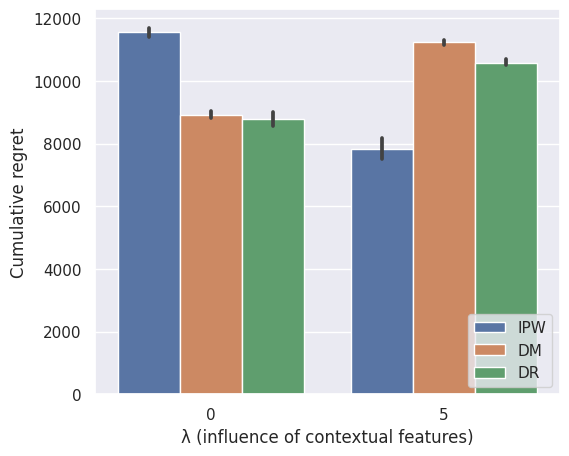

In [13]:
plt.figure(figsize=(6, 5), facecolor="w")

sns.barplot(data=al, x='lambda', y='value', hue='variable')
plt.ylabel('Cumulative regret')
plt.xlabel('λ (influence of contextual features)')
plt.legend( loc='lower right', fontsize=11)
#plt.tight_layout()

In [14]:
al

,lambda,variable,value
0,0,IPW,11325
1,0,IPW,11695
2,0,IPW,11516
3,0,IPW,11798
4,0,IPW,11410
5,5,IPW,8115
6,5,IPW,7499
7,5,IPW,7311
8,5,IPW,8428
9,5,IPW,7852
